### Parisa Kamizi ADS 509 Module 6 Assingmnet 6.1

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [80]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [114]:
# Add any additional import statements you need here

import glob
import seaborn as sns

In [84]:
# change `data_location` to the location of the folder on your machine.
#data_location = "/users/rsadeghian/textmining/ads-tm-api-scrape/"
data_location = "/Users/parisakamizi/Desktop/ADS509/Module Two/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [87]:
lyrics_path = os.path.join(data_location, lyrics_folder)
twitter_path = os.path.join(data_location, twitter_folder)

# Read lyrics data 
lyrics_data = []
for artist_folder in glob.glob(os.path.join(lyrics_path, "*")):
    if os.path.isdir(artist_folder):
        artist = os.path.basename(artist_folder)
        for lyric_file in glob.glob(os.path.join(artist_folder, "*.txt")):
            song = os.path.splitext(os.path.basename(lyric_file))[0].split("_", 1)[-1]
            with open(lyric_file, 'r', encoding='utf-8') as infile:
                lyrics = infile.readlines()[4:]  # Skip first 4 lines (title, blanks)
                lyrics_data.append((artist, song, "".join(lyrics)))

# Convert to DataFrame
lyrics_df = pd.DataFrame(lyrics_data, columns=['artist', 'song', 'lyrics'])



In [90]:
# Read Twitter data 
artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}

twitter_df = pd.concat(
    [
        pd.read_csv(os.path.join(twitter_path, file), sep="\t", quoting=3).assign(artist=artist)
        for artist, file in artist_files.items()
    ],
    ignore_index=True
)

In [92]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read sentiment words into a dictionary
sentiment = {}

def load_sentiment_words(file_path, sentiment_value):
    with open(file_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            line = line.strip()
            if line and line.isalpha() and not line.startswith(";"):  
                sentiment[line] = sentiment_value

load_sentiment_words(positive_words_file, 1)
load_sentiment_words(negative_words_file, -1)

# Read tidy text file
with open(tidy_text_file, 'r', encoding='utf-8') as infile:
    next(infile)  
    for line in infile:
        word, sent, _ = line.strip().split("\t")
        sentiment[word] = 1 if sent == "positive" else -1 if sent == "negative" else sentiment.get(word, 0)


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [94]:
def get_sentiment(text, sent_dict=sentiment):
    words = text.lower().split()
    return sum(sent_dict.get(word, 0) for word in words)  

# Compute sentiment for each song
lyrics_df['sentiment'] = lyrics_df['lyrics'].map(get_sentiment)

# Compute average sentiment per artist
avg_sentiment = lyrics_df.groupby('artist')['sentiment'].mean()
print(avg_sentiment)

# Function to get and print top/bottom sentiment songs for an artist
def analyze_artist(artist_name):
    artist_songs = lyrics_df[lyrics_df['artist'] == artist_name]
    top_3_songs = artist_songs.nlargest(3, 'sentiment')
    bottom_3_songs = artist_songs.nsmallest(3, 'sentiment')

    def print_lyrics(songs, label):
        print(f"\n{'='*20} {artist_name} - {label} {'='*20}")
        print("\n\n".join(songs['lyrics'].tolist()))
        print("="*50)

    print_lyrics(top_3_songs, "Top 3 Positive Songs")
    print_lyrics(bottom_3_songs, "Top 3 Negative Songs")

analyze_artist('cher')
analyze_artist('robyn')


artist
cher     5.955696
robyn    7.644231
Name: sentiment, dtype: float64

==================== cher - Top 3 Positive Songs ====================
Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and unders

In [98]:
def get_sentiment(text, sent_dict=sentiment):
    words = text.lower().split()
    return sum(sent_dict.get(word, 0) for word in words)  

# Compute sentiment for each song
lyrics_df['sentiment'] = lyrics_df['lyrics'].map(get_sentiment)

# Function to get top/bottom sentiment song names for an artist
def list_top_bottom_songs(artist_name):
    artist_songs = lyrics_df[lyrics_df['artist'] == artist_name]
    top_3_songs = artist_songs.nlargest(3, 'sentiment')['song'].tolist()
    bottom_3_songs = artist_songs.nsmallest(3, 'sentiment')['song'].tolist()

    print(f"\n{'='*20} {artist_name} {'='*20}")
    print("Top 3 Positive Songs:", ", ".join(top_3_songs))
    print("Top 3 Negative Songs:", ", ".join(bottom_3_songs))
    print("="*50)

unique_artists = lyrics_df['artist'].unique()
for artist in unique_artists:
    list_top_bottom_songs(artist)



==================== robyn ====================
Top 3 Positive Songs: loveisfree, wedancetothebeat114528, wedancetothebeat
Top 3 Negative Songs: dontfuckingtellmewhattodo, dontfuckingtellmewhattodo114520, criminalintent

==================== cher ====================
Top 3 Positive Songs: loveandunderstanding, ifoundyoulove, perfection
Top 3 Negative Songs: bangbang, outrageous, iwalkonguildedsplinters


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: <!-- Your answer here --> Robyn has the highest average sentiment per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here --> Artist Cher top songs are love and understanding, i found you love and perfection, while her bottom songs are bangbang, outrageous and i walk on guilded splinters. Robyn top songs are we dance to the beat 114528, we dance to the beat and love is free. Robyn bottom songs are don't fucking tell me what to do, criminal intent and don't fucking tell me what to do 114520. The sentiment score is driven by the emotional tone and word choices in the lyrics. Songs with high sentiment scores likely contain positive words related to love, happiness, and hope, while lower sentiment scores are influenced by themes of sadness, heartbreak, loss and cursing. 

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here --> For the sentiment score, it is influenced by the emotional language in the lyrics. The frequency and intensity of these words impact the overall sentiment calculation.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.



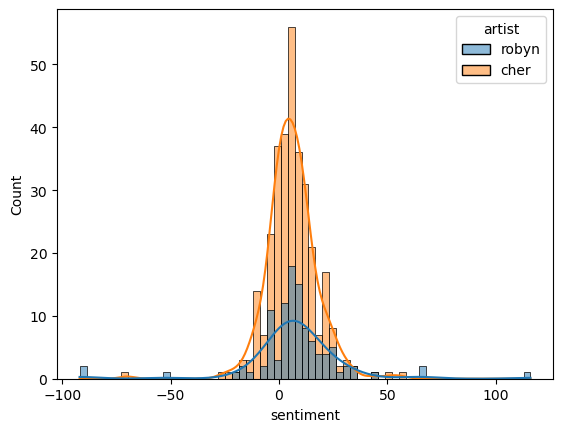

In [108]:
# Plot sentiment for each artist
sns.histplot(data=lyrics_df, x='sentiment', hue='artist', kde=True)
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [111]:
# your code here

# Define emoji sentiment sets
positive_emojis = {"😊", "😁", "😂", "😍", "🤩", "🥳", "❤️", "🎉", "👍", "😇"}
negative_emojis = {"😢", "😡", "😭", "😠", "😞", "💔", "👎", "😖", "🥺", "😨"}
emoji_sentiment = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment.update({emoji: -1 for emoji in negative_emojis})

# Function to compute sentiment score
def calculate_emoji_sentiment(text):
    if isinstance(text, str): 
        return sum(emoji_sentiment.get(char, 0) for char in text)
    return 0  

twitter_df['description'] = twitter_df['description'].fillna("")

# Apply function to Twitter follower descriptions
twitter_df['emoji_sentiment'] = twitter_df['description'].apply(calculate_emoji_sentiment)

# Compute average sentiment per artist
avg_emoji_sentiment = twitter_df.groupby('artist')['emoji_sentiment'].sum() / twitter_df.groupby('artist').size()

print(avg_emoji_sentiment)

artist
cher     0.005673
robyn    0.002419
dtype: float64


Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> The values are demonstrated above. Cher is 0.0057 and Robyn is 0.0024

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> The result is demonstrated below.



In [69]:
# Function to extract emojis from text
def extract_emojis(text):
    return [char for char in text if char in emoji_sentiment]

# Apply function to extract emojis
twitter_df['extracted_emojis'] = twitter_df['description'].apply(lambda x: extract_emojis(x) if isinstance(x, str) else [])

# Count emojis for each artist
emoji_counts = twitter_df.explode('extracted_emojis').groupby('artist')['extracted_emojis'].apply(lambda x: Counter(x).most_common())

# Find the most popular positive and negative emoji for each artist
for artist, counts in emoji_counts.items():
    positive_emoji = next((emoji for emoji, _ in counts if emoji in positive_emojis), None)
    negative_emoji = next((emoji for emoji, _ in counts if emoji in negative_emojis), None)
    
    print(f"Artist: {artist}")
    print(f"Most popular positive emoji: {positive_emoji if positive_emoji else 'None found'}")
    print(f"Most popular negative emoji: {negative_emoji if negative_emoji else 'None found'}\n")


Artist: cher
Most popular positive emoji: 😍
Most popular negative emoji: 💔

Artist: robyn
Most popular positive emoji: 😍
Most popular negative emoji: 💔



### References

##### Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for Text Analytics Using Python. O'Reilly Media.
##### Home Assignment of Module 1, 2.
##### ChatGPT (OpenAI) was utilized as a learning tool.